In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subroutines import ModelEstV2,ApproxDAP,max_norm,find_stable_radius,SafeTransit
from time import time
from Controllers import SafeDAP
from scipy.linalg import sqrtm
import pickle as pkl
%load_ext autoreload
%autoreload 2

In [2]:
class TimeStepsReached(Exception):
    pass

# Set up the system

## Find a highly stable spring-mass system

Spectral radius of A: 0.8527801392651051 2.238998901199829 2.951560230869864
Step 0
Step 100
Step 0
Step 100


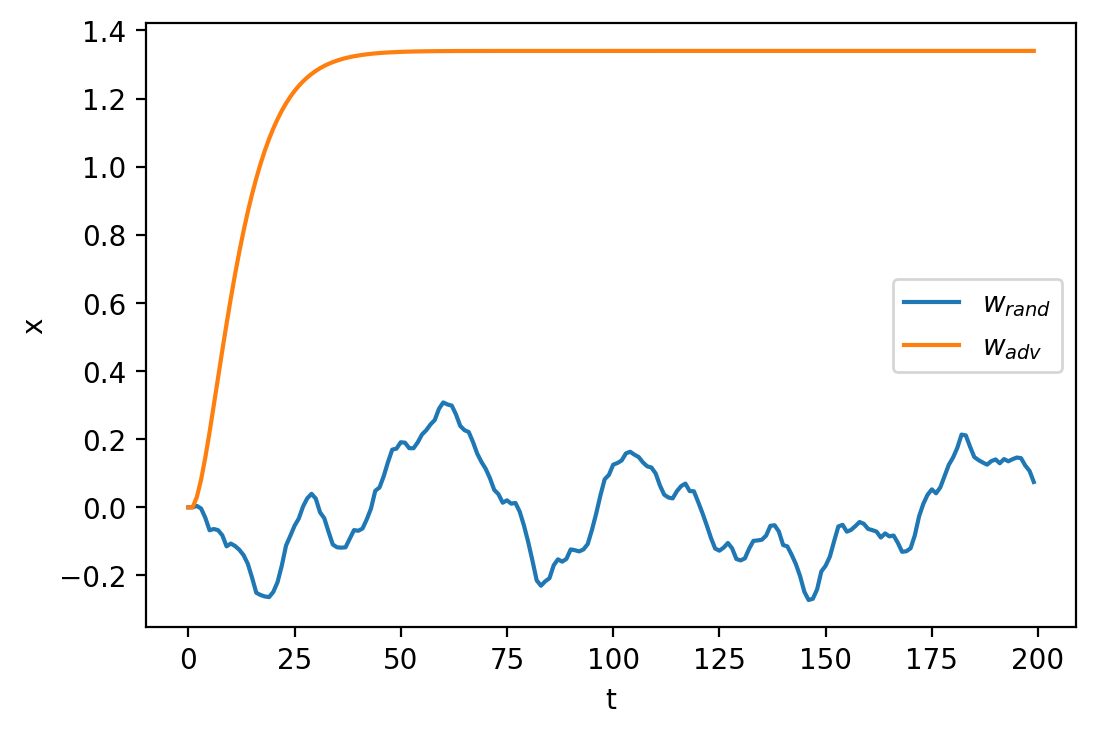

In [3]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.3
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

In [4]:

A = env.A
B = env.B


# Experiments

## Experiment parameters

In [5]:
for eta_bar in [0.1,0.5,1.0,1.5,2.0]: # The magnitude of exploration noise.

    # Find a region(B(A,eps_init)) around A and ensure it contains only stable matrices.
    eps_init = find_stable_radius(A)

    est = ModelEstV2(A,B,eps_init) # The model estimator.

    H = 20 # Look back length



    # Constants
    x_dim = A.shape[-1]
    u_dim = B.shape[-1]

    I_x = np.eye(x_dim)  
    I_u = np.eye(u_dim)  


    w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.

    # Optimaization Problem Parameters

    Q = np.array([[1,0],
                    [0,1]])*1
    R = np.eye(u_dim)*1

    D_x = np.vstack([I_x,-I_x]) # Constraints
    # d_x = np.array([0.5,0.5,0.5,0.5])
    d_x = np.array([4,6.0,4,6.0])

    D_u = np.vstack([I_u,-I_u])
    d_u = np.array([6,6])

    w_max = env.w_max 

    M0 = np.zeros((H,u_dim,x_dim))

    e_x = 0 # Usually e_x is not zero 
    e_u = 0 # For safe DAP with known B, e_u = 0

    refit_per_step = 50
    pre_run_steps = 2
    TD_steps  = 30 # The least number of steps taken in Phase 1.


    params = {'Q':Q,'R':R,'D_x':D_x,'d_x':d_x,'D_u':D_u,'d_u':d_u,'A':A,'B':B,'H':H,'eta_bar':eta_bar}
    with open('Parameters.pkl','wb') as f:
        pkl.dump(params,f)

    def SafeAdaptiveSim(timesteps):
        # Data containers

        x_hist = []
        u_hist = []
        w_hat_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]

        theta_hist = []
        refit_time_step = []
        phase1_endpoints =[]
        phase2_endpoints=[]
        M_hist = [M0]
        r_hist = []

        n_episode = 0

        def phase(A_hat,B_hat,old_eta,new_eta):
            # Local variables: A_hat,B_hat,old,new.
            # Global variables: theta_hist,M_hist,e_x,e_u,H,env,w_max, w_hat_hist
            # Start of the phase
            # Solve for new controller M.
            M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)

            if n_episode==1:
                 old = {'M':np.array(M),'theta':(np.array(A_hat),np.array(B_hat)),'eta':old_eta,'r':r_hist[-1]}
            else:
                old = {'M':np.array(M_hist[-1]),'theta':theta_hist[-2],'eta':old_eta,'r':r_hist[-2]}
            new = {'M':np.array(M),'theta':theta_hist[-1],'eta':new_eta,'r':r_hist[-1]}

            old['e_x']=new['e_x']=e_x
            old['e_u']=new['e_u']=e_u

            M_hist.append(np.array(M))

            # Compute mid.
            mid = safeDapSolver.mid(old,new,H)

            transit = SafeTransit(old,new,mid,H)

            for i in range(refit_per_step):
                x = env.state()
                u = transit.get_u(w_hat_hist)
                env.step(u)

                Ah,Bh = transit.get_theta()
                # Calculate the estimated disturbance, and project it onto the bounded disturbance set. 
                w_hat = env.state()-Ah.dot(x)-Bh.dot(u)
                w_hat[w_hat>w_max] = w_max
                w_hat[w_hat<-w_max] = -w_max 
                w_hat_hist.append(np.array(w_hat)) 

                u_hist.append(u)
                x_hist.append(x)

                if len(x_hist)>=timesteps:
                    raise TimeStepsReached # Use the exception mechanism to stop the main loop once the total timestep is reached.

                # Updating M in the transit object.
                transit.step()
            # End of the phase


        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

        safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

        try:
        # main loop
            while True:

                if n_episode==0:
                    for i in range(pre_run_steps):
                        x = env.state()
                        x_hist.append(x)
                        u = (np.random.rand()-0.5)*2*eta_bar
                        env.step(u)
                        u_hist.append(u)
                    A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
                    theta_hist.append((np.array(A_hat),np.array(B_hat)))
                    r_hist.append(float(r))
                    refit_time_step.append(len(x_hist))
    #                 print(A_hat,B_hat)

                    # Fit the system parameters for the first time.
                else:

                    M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)
                    M_hist.append(np.array(M))

                    # Phase 1: exploration exploitation 

                    print('phase 1')
                    phase(A_hat,B_hat,0,eta_bar)

                    phase1_endpoints.append(len(x_hist))

                    # Refit the system model
                    A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
                    theta_hist.append((np.array(A_hat),np.array(B_hat)))
                    r_hist.append(float(r))
                    refit_time_step.append(len(x_hist))

                    # Phase 2: pure exploitation 
                    print('phase 2')
                    phase(A_hat,B_hat,eta_bar,0)

                    phase2_endpoints.append(len(x_hist))


                    print('Episode',n_episode)

                n_episode+=1

        except TimeStepsReached:
            print('Time Steps Reached')
            # Prepare data output
            data = {}
            data['x'] = x_hist
            data['u'] = u_hist
            data['theta'] = theta_hist
            data['w'] = w_hat_hist
            return data


    def PlainSim(timesteps):
        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

        x_no_control_hist = []
        # main loop
        for _ in range(timesteps):
            x = env.state()
            u = 0 
            env.step(u)

            x_no_control_hist.append(x)

            if _%100 == 0:
                print('Step',_)

        data = {}
        data['x'] = x_no_control_hist
        return data

    def BenchmarkSim(timesteps):
        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

        safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

        x_true_hist = []
        u_true_hist = []
        w_true_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]

        # M,Phi = safeDapSolver.solve(A_final,B,H,e_x=e_x,e_u=e_u)
        M,Phi = safeDapSolver.solve(A,B,H,e_x=e_x,e_u=e_u)
        # M,Phi = safeDapSolver.solve(theta_hist[-1][0],theta_hist[-1][1],H,e_x=e_x,e_u=e_u)

        # main loop
        for _ in range(timesteps):
            x = env.state()
            x_true_hist.append(x)
            if _<pre_run_steps:
                u = (np.random.rand()-0.5)*2*0
            else:
                u = ApproxDAP(M,w_true_hist,0)

            env.step(u)
            u_true_hist.append(u)

            w_true_hist.append(env.state()-A.dot(x_true_hist[-1])-B.dot(u_true_hist[-1]))

            if _%100 == 0:
                print('Step',_)

        # Prepare data output
        data = {}
        data['x'] = x_true_hist
        data['u'] = u_true_hist
        data['w'] = w_true_hist
        return data

#     alg_dict = {'SafeLearning':SafeAdaptiveSim,'Plain':PlainSim,'Benchmark':BenchmarkSim}
    
    alg_dict = {'Benchmark':BenchmarkSim}

    n_trials = 10
    time_steps = 400
    for key, alg in alg_dict.items():
        print("{} starts.".format(key))
        trial_data = []
        for _ in range(n_trials):
            print('Trial {}'.format(_))
            trial_data.append(alg(time_steps))

        with open('{}_eta_{}.pkl'.format(key,eta_bar),'wb') as f:
            pkl.dump(trial_data,f)

0.9673821795435633
Benchmark starts.
Trial 0
Step 0
Step 100
Step 200
Step 300
Trial 1
Step 0
Step 100
Step 200
Step 300
Trial 2
Step 0
Step 100
Step 200
Step 300
Trial 3
Step 0
Step 100
Step 200
Step 300
Trial 4
Step 0
Step 100
Step 200
Step 300
Trial 5
Step 0
Step 100
Step 200
Step 300
Trial 6
Step 0
Step 100
Step 200
Step 300
Trial 7
Step 0
Step 100
Step 200
Step 300
Trial 8
Step 0
Step 100
Step 200
Step 300
Trial 9
Step 0
Step 100
Step 200
Step 300
0.969295695106621
Benchmark starts.
Trial 0
Step 0
Step 100
Step 200
Step 300
Trial 1
Step 0
Step 100
Step 200
Step 300
Trial 2
Step 0
Step 100
Step 200
Step 300
Trial 3
Step 0
Step 100
Step 200
Step 300
Trial 4
Step 0
Step 100
Step 200
Step 300
Trial 5
Step 0
Step 100
Step 200
Step 300
Trial 6
Step 0
Step 100
Step 200
Step 300
Trial 7
Step 0
Step 100
Step 200
Step 300
Trial 8
Step 0
Step 100
Step 200
Step 300
Trial 9
Step 0
Step 100
Step 200
Step 300
0.9693180651380429
Benchmark starts.
Trial 0
Step 0
Step 100
Step 200
Step 300
Trial 1
